# 1. Introduction
In this notebook, we analyze Tesla (TSLA) stock using a Gaussian Hidden Markov Model (HMM) to identify market regimes such as bullish and bearish phases. The workflow includes data collection, preprocessing, model training, state decoding, and interpretation of transitions.


## 2. Installing Required Libraries


In [5]:
!pip install yfinance
!pip install pandas
!pip install hmmlearn


## 3. Importing Libraries


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

plt.style.use("seaborn-v0_8")


# 4. Data Collection
We download TSLA stock price data from Yahoo Finance beginning from 2014.


In [7]:
symbol = "TSLA"
stock_data = yf.download(symbol, start="2014-01-01")
stock_data.head(), stock_data.columns


C:\Users\DIVYA JHA\AppData\Local\Temp\ipykernel_11340\3175742839.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed


(Price           Close       High       Low       Open    Volume
 Ticker           TSLA       TSLA      TSLA       TSLA      TSLA
 Date                                                           
 2014-01-02  10.006667  10.165333  9.770000   9.986667  92826000
 2014-01-03   9.970667  10.146000  9.906667  10.000000  70425000
 2014-01-06   9.800000  10.026667  9.682667  10.000000  80416500
 2014-01-07   9.957333  10.026667  9.683333   9.841333  75511500
 2014-01-08  10.085333  10.246667  9.917333   9.923333  92448000,
 MultiIndex([( 'Close', 'TSLA'),
             (  'High', 'TSLA'),
             (   'Low', 'TSLA'),
             (  'Open', 'TSLA'),
             ('Volume', 'TSLA')],
            names=['Price', 'Ticker']))

## 5. Data Exploration
This section checks column names, dataset size, and basic structure.


In [8]:
print("Columns ->", stock_data.columns)
print("Total elements ->", stock_data.size)


Columns -> MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])
Total elements -> 14960


# 6. Data Preprocessing
We extract the close price, compute daily returns, and prepare the data for HMM.


In [9]:
closing_val = stock_data[('Close', 'TSLA')].copy()
df = closing_val.to_frame(name="Close")
df["Return"] = df["Close"].pct_change()
df = df.dropna()

returns = df["Return"].values.reshape(-1, 1)
dates = df.index
df.head()


,Close,Return
Date,,
2014-01-03,9.970667,-0.003598
2014-01-06,9.800000,-0.017117
2014-01-07,9.957333,0.016054
2014-01-08,10.085333,0.012855
2014-01-09,9.835333,-0.024788


# 7. Gaussian Hidden Markov Model (HMM)
We train a 2-state HMM to separate price dynamics into hidden market regimes.


## 7.1 Training the HMM Model


In [10]:
model = GaussianHMM(n_components=5, covariance_type="full", n_iter=300)
model.fit(returns)

hidden_states = model.predict(returns)
hidden_states


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## 7.2 Analyzing State Parameters
Positive mean = bullish phase  
Negative mean = bearish phase


In [11]:
means = model.means_.flatten()
variances = np.array([np.diag(cov)[0] for cov in model.covars_])

for i in range(model.n_components):
    print(f"STATE {i}: Mean = {means[i]:.6f}, Variance = {variances[i]:.6f}")

print("Positive mean → bullish phase (uptrend)")
print("Negative mean → bearish phase (downtrend)")


STATE 0: Mean = 0.004057, Variance = 0.003356
STATE 1: Mean = 0.001063, Variance = 0.000540
Positive mean → bullish phase (uptrend)
Negative mean → bearish phase (downtrend)


# 8. Market Regime Detection
We assign the predicted hidden state to each date and visualize the behavior.


## 8.1 Creating State-Labeled DataFrame


In [12]:
regime_df = df.copy()
regime_df["State"] = hidden_states
regime_df.head()


,Close,Return,State
Date,,,
2014-01-03,9.970667,-0.003598,1
2014-01-06,9.800000,-0.017117,1
2014-01-07,9.957333,0.016054,1
2014-01-08,10.085333,0.012855,1
2014-01-09,9.835333,-0.024788,1


## 8.2 Plotting Prices by Hidden State


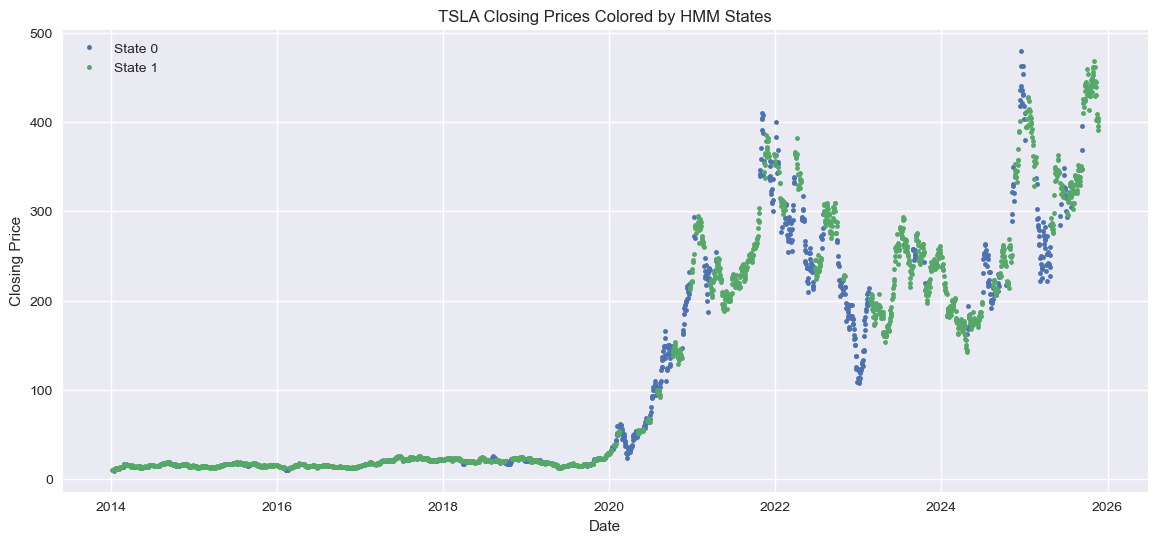

In [13]:
plt.figure(figsize=(14,6))

for state in range(model.n_components):
    segment = regime_df[regime_df["State"] == state]
    plt.plot(segment.index, segment["Close"], ".", label=f"State {state}")

plt.title("TSLA Closing Prices Colored by HMM States")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


## 8.3 Daily Returns by Hidden State


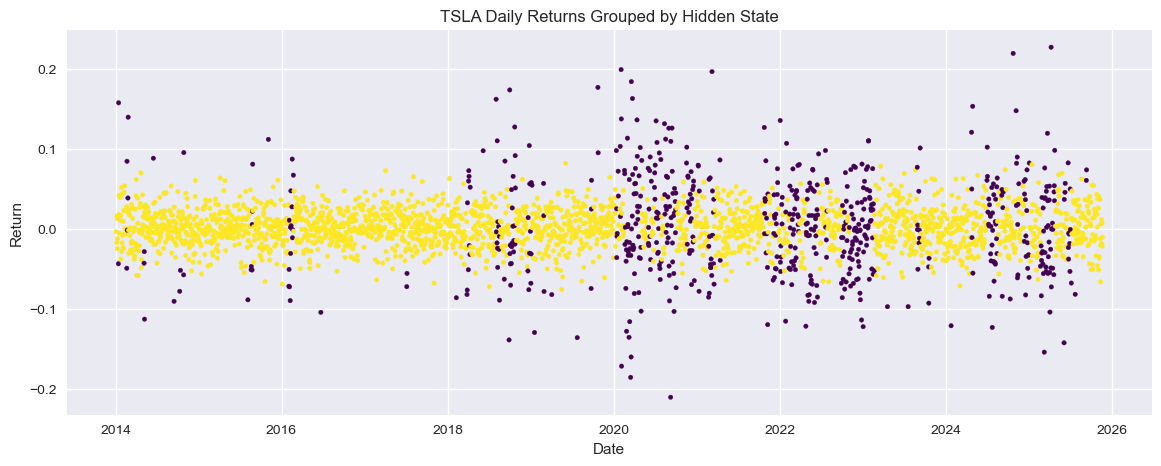

In [14]:
plt.figure(figsize=(14,5))
plt.scatter(regime_df.index, regime_df["Return"], c=regime_df["State"], cmap="viridis", s=10)
plt.title("TSLA Daily Returns Grouped by Hidden State")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


## 8.4 BONUS - Multi-State HMM (3/4/5 States)

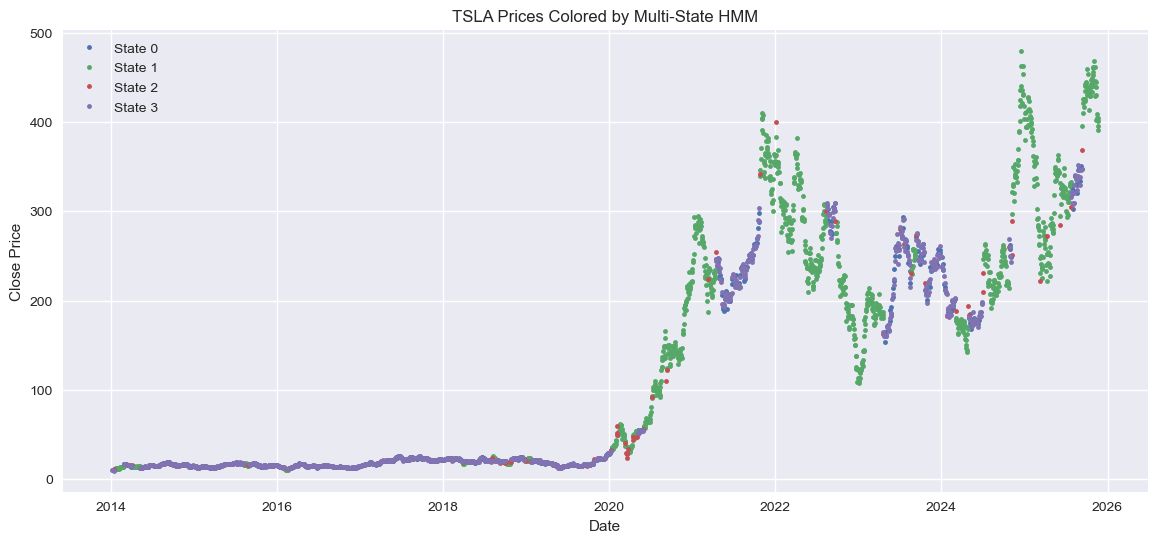

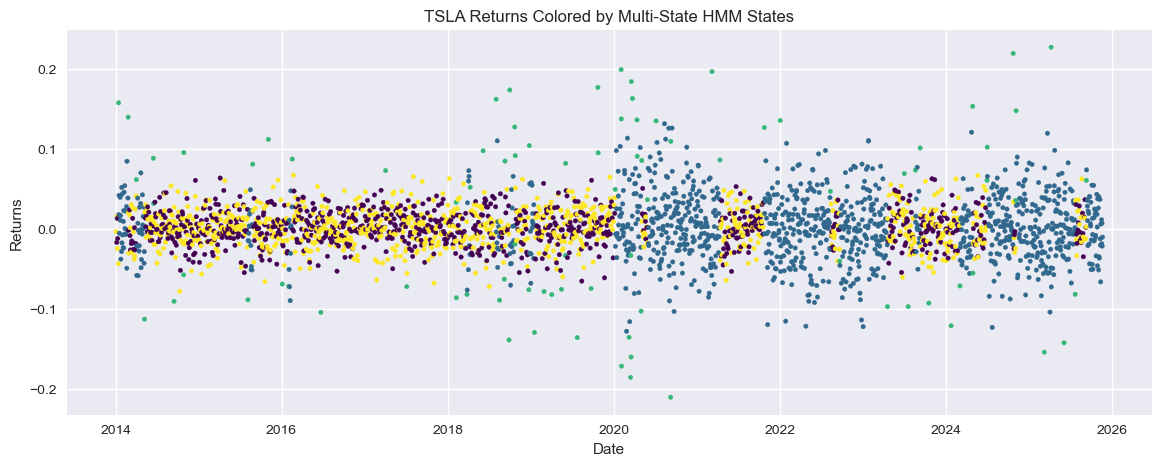


State Mean & Variance:
State 0: Mean = 0.000994, Variance = 0.000434
State 1: Mean = 0.000972, Variance = 0.001562
State 2: Mean = 0.011129, Variance = 0.006917
State 3: Mean = 0.001545, Variance = 0.000544


In [20]:
# BONUS 1 — Multi-State HMM (3–6 States)

import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Use your already preprocessed df and returns
returns = df["Return"].values.reshape(-1, 1)

# Change n_components to 3, 4, 5, or 6
model_multi = GaussianHMM(n_components=4, covariance_type="full", n_iter=300)
model_multi.fit(returns)

hidden_states_multi = model_multi.predict(returns)

df_multi = df.copy()
df_multi["State"] = hidden_states_multi

# ----- Plot Prices -----
plt.figure(figsize=(14,6))
for state in range(model_multi.n_components):
    seg = df_multi[df_multi["State"] == state]
    plt.plot(seg.index, seg["Close"], '.', label=f"State {state}")

plt.title("TSLA Prices Colored by Multi-State HMM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# ----- Plot Returns -----
plt.figure(figsize=(14,5))
plt.scatter(df_multi.index, df_multi["Return"], c=df_multi["State"], cmap="viridis", s=10)
plt.title("TSLA Returns Colored by Multi-State HMM States")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# ----- Print Means & Variances -----
print("\nState Mean & Variance:")
for s in range(model_multi.n_components):
    print(f"State {s}: Mean = {model_multi.means_[s][0]:.6f}, Variance = {np.diag(model_multi.covars_[s])[0]:.6f}")

## 8.5 Comparing Assests (TSLA vs NVDA)

C:\Users\DIVYA JHA\AppData\Local\Temp\ipykernel_11340\1849346727.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data2 = yf.download(["TSLA", other_symbol], start="2014-01-01")["Close"]
[*********************100%***********************]  2 of 2 completed


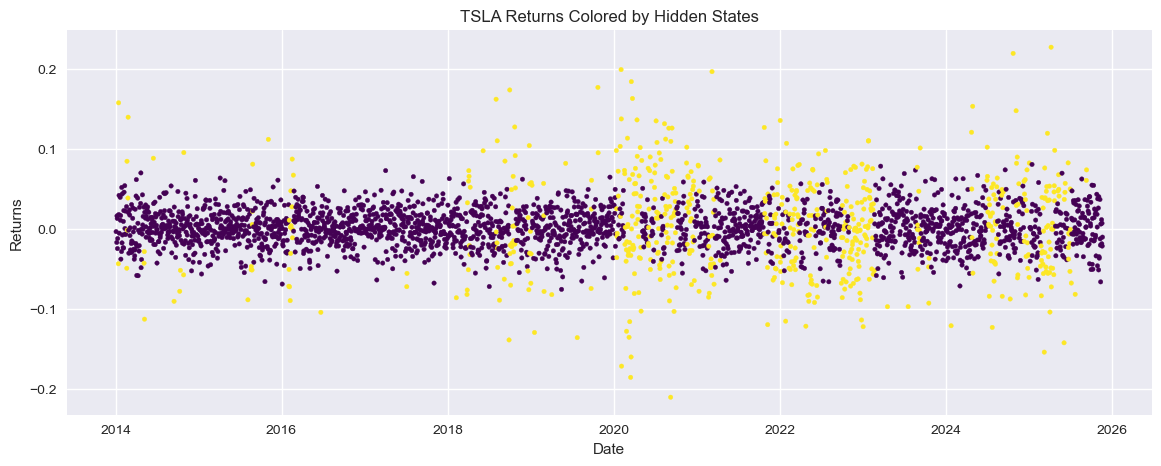


TSLA State Statistics:
State 0: Mean = 0.001063, Variance = 0.000537
State 1: Mean = 0.004043, Variance = 0.003353


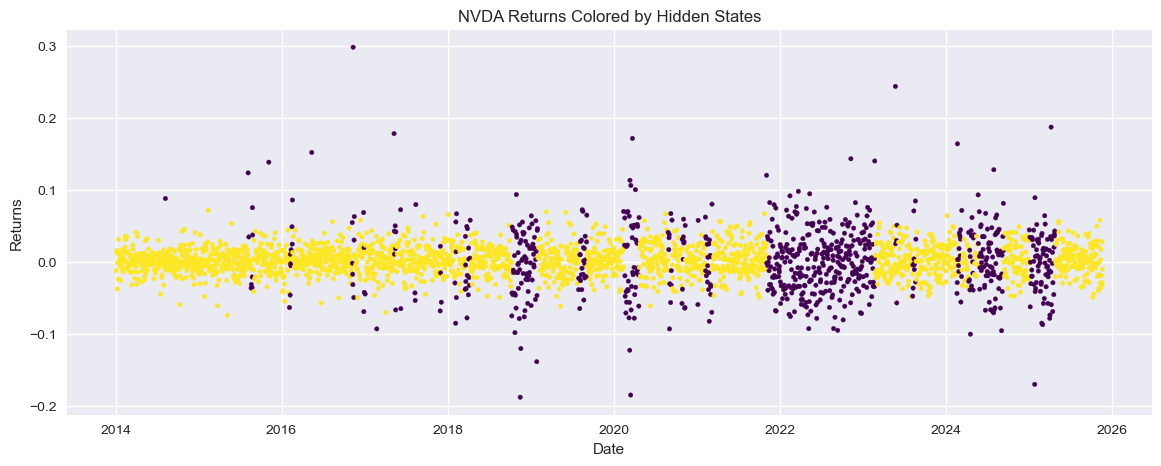


NVDA State Statistics:
State 0: Mean = 0.001706, Variance = 0.002201
State 1: Mean = 0.002832, Variance = 0.000359


In [21]:
# BONUS 2 — Compare TSLA with NVDA

import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ----------------------------
# Use NVDA as comparison asset
# ----------------------------
other_symbol = "NVDA"

# Download TSLA + NVDA closing prices
data2 = yf.download(["TSLA", other_symbol], start="2014-01-01")["Close"]

# Function to preprocess + run HMM
def run_hmm(close_series, label):
    df = close_series.to_frame(name="Close")
    df["Return"] = df["Close"].pct_change()
    df = df.dropna()

    returns = df["Return"].values.reshape(-1, 1)

    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=300)
    model.fit(returns)

    df["State"] = model.predict(returns)

    # ---- Plot Returns by Hidden State ----
    plt.figure(figsize=(14,5))
    plt.scatter(df.index, df["Return"], c=df["State"], cmap="viridis", s=10)
    plt.title(f"{label} Returns Colored by Hidden States")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.show()

    # ---- Print Statistics ----
    print(f"\n{label} State Statistics:")
    for s in range(model.n_components):
        print(f"State {s}: Mean = {model.means_[s][0]:.6f}, "
              f"Variance = {np.diag(model.covars_[s])[0]:.6f}")

    return df, model


# Run HMM for TSLA
tsla_df, tsla_model = run_hmm(data2["TSLA"], "TSLA")

# Run HMM for NVDA
nvda_df, nvda_model = run_hmm(data2[other_symbol], other_symbol)

# 9. Transition Analysis
We examine transition probabilities and expected duration of each state.


## 9.1 Transition Matrix of HMM


In [15]:
print("Transition Matrix:")
print(model.transmat_)


Transition Matrix:
[[0.81730203 0.18269797]
 [0.06758884 0.93241116]]


## 9.2 Regime Visualization (Repeated for Transition Analysis)


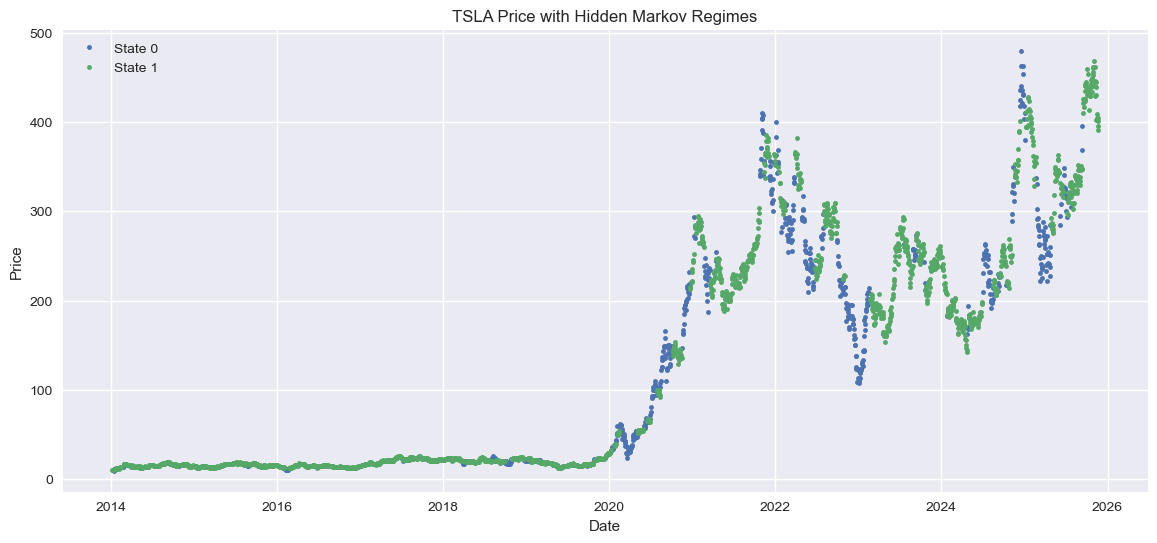

In [16]:
plt.figure(figsize=(14,6))
for state in range(model.n_components):
    segment = regime_df[regime_df["State"] == state]
    plt.plot(segment.index, segment["Close"], ".", label=f"State {state}")

plt.title("TSLA Price with Hidden Markov Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## 9.3 Expected State Duration  
Duration = 1 / (1 − stay_probability)


In [17]:
for state in range(model.n_components):
    stay = model.transmat_[state, state]
    expected_duration = 1 / (1 - stay)
    print(f"Expected Duration in State {state}: {expected_duration:.2f} days")


Expected Duration in State 0: 5.47 days
Expected Duration in State 1: 14.80 days


# 10. Predicting Future Regime Probabilities
## 10.1 Identifying Current Regime and Next-Day Probabilities


In [18]:
current_state = hidden_states[-1]
print("Current State:", current_state)
print("Transition probabilities for next day:", model.transmat_[current_state])


Current State: 1
Transition probabilities for next day: [0.06758884 0.93241116]


## 10.2 Predicting Probabilities for the Next 10 Days


In [19]:
dist = np.zeros(model.n_components)
dist[current_state] = 1.0

for day in range(10):
    dist = dist @ model.transmat_
    print(f"Probability distribution after {day+1} days: {dist}")


Probability distribution after 1 days: [0.06758884 0.93241116]
Probability distribution after 2 days: [0.11826109 0.88173891]
Probability distribution after 3 days: [0.15625074 0.84374926]
Probability distribution after 4 days: [0.18473209 0.81526791]
Probability distribution after 5 days: [0.20608492 0.79391508]
Probability distribution after 6 days: [0.22209343 0.77790657]
Probability distribution after 7 days: [0.23409522 0.76590478]
Probability distribution after 8 days: [0.24309311 0.75690689]
Probability distribution after 9 days: [0.24983896 0.75016104]
Probability distribution after 10 days: [0.2548964 0.7451036]


# 11. Conclusion
The Gaussian HMM successfully identifies hidden market regimes in Tesla's stock. 
The model provides:
- Bullish vs bearish regime detection  
- State transition probabilities  
- Expected duration in each regime  
- Short-term future regime probability forecasts  

This helps in understanding structural patterns in price behavior rather than predicting exact future prices.
